In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import fsolve
%matplotlib inline


In [2]:
#No. of. Assets
n=5
Notional = 100

#Stock Prices
s_array = np.array([1 for i in range(0,n)])

#Dividend
delta = np.array([0 for i in range(0, n)])

#Volatility
vol_array = np.array([0.518, 0.648, 0.623, 0.570, 0.530])

# Risk-free Interest Rate
r=0.05

# Time to maturity for the basket option
T=1  

# Weights of each stock in the basket option
w_array = np.array([0.381, 0.065, 0.057, 0.270, 0.227])

# Strike price of the basket
K=1

def stockSim(S0, r, delta, sigma, T, x):
    return S0*np.exp((r-delta-(sigma**2)/2)*T + sigma*np.sqrt(T)*norm.ppf(x))



In [7]:
PV_dict = {'Runs:50000':[] , 'Runs:500000':[] , 'Runs:5000000':[]}

for sim in [50000, 500000, 5000000]:
    PV_list = []
    for run in range(0, 30):
        rand_unif_sim = np.random.rand(sim).reshape(-1,)
        sim_underlying = 0
        for i in range(0,n):
            sim_underlying = sim_underlying + w_array[i] * stockSim(s_array[i], r, delta[i], vol_array[i], T, rand_unif_sim) 

        payoff = np.maximum(K-sim_underlying, 0)
        PV = np.mean(payoff) * Notional * np.exp(-r*T)
        PV_list.append(PV)
        
    PV_dict['Runs:'+str(sim)] = PV_list

df = pd.DataFrame(PV_dict)

In [8]:
df.to_csv('df_pv_comonotonic_mc.csv')

Closed Form Co-Monotonic Multi-European Price:  18.74594555872481


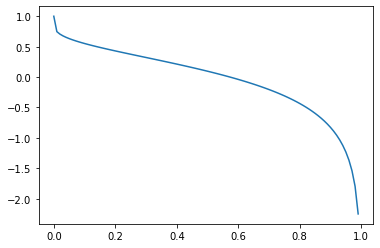

In [17]:
# Closed-form Solution

def fwd_PnL_func(s_array, r, delta, vol_array, w_array, T, n, x):
    sim_underlying = 0
    for i in range(0,n):
        sim_underlying = sim_underlying + w_array[i] * stockSim(s_array[i], r, delta[i], vol_array[i], T, x) 
    fwd_PnL = K-sim_underlying
    return fwd_PnL

def d1(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))

def d2(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))

def BSMcall(S0, r, delta, t0, t, k, sigma):
    return S0*np.exp(-delta*(t-t0))*norm.cdf(d1(S0, r, delta, t0, t, k, sigma)) - k*np.exp(-r*(t-t0))*norm.cdf(d2(S0, r, delta, t0, t, k, sigma))

def BSMPut(S0, r, delta, t0, t, k, sigma):
    return k*np.exp(-r*(t-t0))*norm.cdf(-d2(S0, r, delta, t0, t, k, sigma)) - S0*np.exp(-delta*(t-t0))*norm.cdf(-d1(S0, r, delta, t0, t, k, sigma))

def fwdValue(S0, r, delta, t0, t, k):
    return S0*np.exp(-delta*(t-t0)) - k*np.exp(-r*(t-t0))

    
# Find uniform rv x where ppf(x) makes stock price such that (K-S(T) == 0):
f = lambda x: fwd_PnL_func(s_array, r, delta, vol_array, w_array, T, n, x)  
x=np.linspace(0,1,101)
plt.plot(x,f(x))

#Solution Guess from plot
sol_guess = 0.7
solved_x=fsolve(f,sol_guess)[0]    
          
#Closed-form Price
strikes_list = [stockSim(s_array[i], r, delta[i], vol_array[i], T, solved_x) for i in range(0,n)]
option_value_list = np.array([BSMPut(s_array[i], r, delta[i], 0, T, strikes_list[i], vol_array[i]) for i in range(0,n)])
PV = np.dot(w_array, option_value_list) * Notional
print("Closed Form Co-Monotonic Multi-European Price: ", PV)
